In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from datetime import datetime
import calendar
from math import sin, cos, sqrt, atan2, radians
from folium import FeatureGroup, LayerControl, Map, Marker
from folium.plugins import HeatMap
import matplotlib.dates as mdates
import matplotlib as mpl
from datetime import timedelta
import datetime as dt
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)
plt.style.use('fivethirtyeight')
import folium
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import Imputer
from sklearn.impute import SimpleImputer
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import pickle

# 1. 데이터 분석 준비

In [2]:
# 데이터 불러오기 
train = pd.read_csv("../data/nyc-taxi-trip-duration/train.csv")
test = pd.read_csv("../data/nyc-taxi-trip-duration/test.csv")

In [3]:
print('train shape : ', train.shape, 'test shape : ', test.shape)

train shape :  (1458644, 11) test shape :  (625134, 9)


In [4]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


### data description 
- id - 각 트립에 대한 고유 식별자
- vendor_id - 주행 기록과 연결된 제공자를 나타내는 코드
- pick_datetime - 미터기가 작동된 날짜 및 시간
- dropoff_datetime - 미터기가 해제된 날짜 및 시간
- passenger_count - 차량에 탑승한 승객 수(운전자 입력 값)
- pickup_longitude - 미터기가 걸려 있던 경도
- pickup_latitude - 미터기가 작동된 위도
- dropoff_longitude - 미터기가 해제된 경도
- dropoff_latitude  - 미터기가 해제된 위도
- store_and_fwd_flag - 이 플래그는 차량이 서버와 연결되지 않았기 때문에 공급업체에 전송하기 전에 트립 레코드를 차량 메모리에 보관했는지 여부를 표시함 
    - Y=store and forward; N=store 및 Forward trip
- trip_timeout - 여행 기간(초)

In [5]:
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
train['dropoff_datetime'] = pd.to_datetime(train['dropoff_datetime'], format='%Y-%m-%d %H:%M:%S')
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


# 2. 데이터 살펴보기

## 1) missing data 찾기 

In [6]:
train[pd.isnull(train)].sum()
### dataset의 길이
print("Min pickup time:", min(train['pickup_datetime']))
print("Max pickup time:", max(train['pickup_datetime']))

Min pickup time: 2016-01-01 00:00:17
Max pickup time: 2016-06-30 23:59:39


## 2) 분석을 위한 새로운 컬럼 생성

### pickup time에서 day, month, hour 정보를 생성

In [7]:
train['pickup_date'] = train['pickup_datetime'].dt.date
train['pickup_day'] = train['pickup_datetime'].apply(lambda x:x.day)
train['pickup_hour'] = train['pickup_datetime'].apply(lambda x:x.hour)
train['pickup_day_of_week'] = train['pickup_datetime'].apply(lambda x:calendar.day_name[x.weekday()])

train['dropoff_date'] = train['dropoff_datetime'].dt.date
train['dropoff_day'] = train['dropoff_datetime'].apply(lambda x:x.day)
train['dropoff_hour'] = train['dropoff_datetime'].apply(lambda x:x.hour)
train['dropoff_day_of_week'] = train['dropoff_datetime'].apply(lambda x:calendar.day_name[x.weekday()])

In [8]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_day,pickup_hour,pickup_day_of_week,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,14,17,Monday,2016-03-14,14,17,Monday
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,12,0,Sunday,2016-06-12,12,0,Sunday
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,19,11,Tuesday,2016-01-19,19,12,Tuesday
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,6,19,Wednesday,2016-04-06,6,19,Wednesday
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,26,13,Saturday,2016-03-26,26,13,Saturday


In [9]:
## 위도 경도 변수 소수점 이하 3자리까지 반올림
train['pickup_latitude_round3']=train['pickup_latitude'].apply(lambda x:round(x,3))
train['pickup_longitude_round3']=train['pickup_longitude'].apply(lambda x:round(x,3))
train['dropoff_latitude_round3']=train['dropoff_latitude'].apply(lambda x:round(x,3))
train['dropoff_longitude_round3']=train['dropoff_longitude'].apply(lambda x:round(x,3))

In [10]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_hour,pickup_day_of_week,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,17,Monday,2016-03-14,14,17,Monday,40.768,-73.982,40.766,-73.965
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,0,Sunday,2016-06-12,12,0,Sunday,40.739,-73.980,40.731,-73.999
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,11,Tuesday,2016-01-19,19,12,Tuesday,40.764,-73.979,40.710,-74.005
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,19,Wednesday,2016-04-06,6,19,Wednesday,40.720,-74.010,40.707,-74.012
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,13,Saturday,2016-03-26,26,13,Saturday,40.793,-73.973,40.783,-73.973


### 위도 경도를 사용하여 km 단위 거리로 계산하기 

In [11]:
def calculateDistance(row):
    R=6376.0 # 지구의 대략적인 반경(km)
    pickup_lat = radians(row['pickup_latitude'])
    pickup_lon = radians(row['pickup_longitude'])
    dropoff_lat = radians(row['dropoff_latitude'])
    dropoff_lon = radians(row['dropoff_longitude'])
    dlon = dropoff_lon -pickup_lon
    dlat = dropoff_lat -pickup_lat
    
    a=sin(dlat /2) **2 +cos(pickup_lat)*cos(dropoff_lat)*sin(dlon/2)**2
    c=2*atan2(sqrt(a), sqrt(1-a))
    distance=R*c
    return distance
    

In [12]:
train['trip_distance'] = train.apply(lambda row:calculateDistance(row), axis=1)
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_day_of_week,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3,trip_distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,Monday,2016-03-14,14,17,Monday,40.768,-73.982,40.766,-73.965,1.499697
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,Sunday,2016-06-12,12,0,Sunday,40.739,-73.980,40.731,-73.999,1.806924
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,Tuesday,2016-01-19,19,12,Tuesday,40.764,-73.979,40.710,-74.005,6.390110
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,Wednesday,2016-04-06,6,19,Wednesday,40.720,-74.010,40.707,-74.012,1.486664
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,Saturday,2016-03-26,26,13,Saturday,40.793,-73.973,40.783,-73.973,1.189521


In [13]:
train['trip_duration_in_hour']=train['trip_duration'].apply(lambda x:x/3600)
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3,trip_distance,trip_duration_in_hour
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,2016-03-14,14,17,Monday,40.768,-73.982,40.766,-73.965,1.499697,0.126389
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,2016-06-12,12,0,Sunday,40.739,-73.980,40.731,-73.999,1.806924,0.184167
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,2016-01-19,19,12,Tuesday,40.764,-73.979,40.710,-74.005,6.390110,0.590000
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,2016-04-06,6,19,Wednesday,40.720,-74.010,40.707,-74.012,1.486664,0.119167
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,2016-03-26,26,13,Saturday,40.793,-73.973,40.783,-73.973,1.189521,0.120833


# 3.  Exploratory Data Analysis
데이터 탐구 분석

Text(0.5, 0, 'Trip Duration (in hour)')

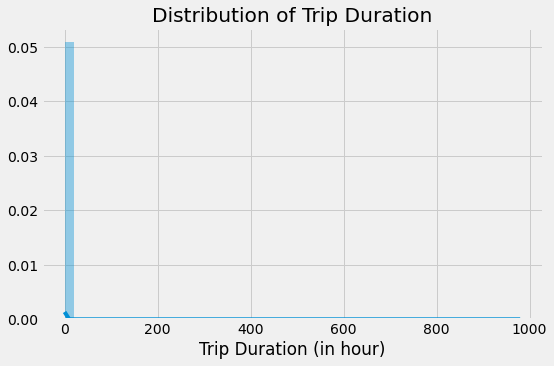

In [14]:
plt.figure(figsize=(8,5))
sns.distplot(train['trip_duration_in_hour']).set_title("Distribution of Trip Duration")
plt.xlabel("Trip Duration (in hour)")

In [15]:
# 24시간 보다 더 긴 시간 여행한 컬럼 생성. 우리는 여기에다가 집중할 것이다.
outlier_trip_duration = train.loc[train['trip_duration_in_hour']>24]
outlier_trip_duration

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3,trip_distance,trip_duration_in_hour
355003,id1864733,1,2016-01-05 00:19:42,2016-01-27 11:08:38,1,-73.789650,40.643559,-73.956810,40.773087,N,...,2016-01-27,27,11,Wednesday,40.644,-73.790,40.773,-73.957,20.164477,538.815556
680594,id0369307,1,2016-02-13 22:38:00,2016-03-08 15:57:38,2,-73.921677,40.735252,-73.984749,40.759979,N,...,2016-03-08,8,15,Tuesday,40.735,-73.922,40.760,-73.985,5.987182,569.327222
924150,id1325766,1,2016-01-05 06:14:15,2016-01-31 01:01:07,1,-73.983788,40.742325,-73.985489,40.727676,N,...,2016-01-31,31,1,Sunday,40.742,-73.984,40.728,-73.985,1.636411,618.781111
978383,id0053347,1,2016-02-13 22:46:52,2016-03-25 18:18:14,1,-73.783905,40.648632,-73.978271,40.750202,N,...,2016-03-25,25,18,Friday,40.649,-73.784,40.750,-73.978,19.916280,979.522778


In [16]:
train['trip_duration'].sort_values(ascending=False)

978383     3526282
924150     2227612
680594     2049578
355003     1939736
1234291    86392  
           ...    
1034341    1      
346102     1      
1360664    1      
1382872    1      
207497     1      
Name: trip_duration, Length: 1458644, dtype: int64

Text(0.5, 1.0, 'Disribution of trip duration (sec) in Log Scale')

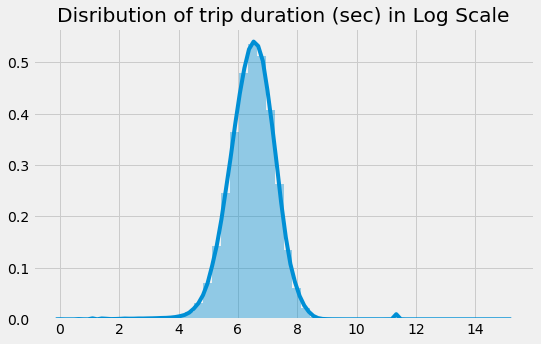

In [17]:
"""
주행 기간이 매우 높은 4개의 기록이 있지만 주행 거리는 매우 낮다. 이것들은 특이치 입니다. 
하지만 이 여행들이 시작되거나 끝나는 특별한 장소가 있을까? 트립 지속시간도 편향되어 있으니 로그 변환을 해보자.
이러한 데이터도 테스트 데이터의 일부일 수 있으므로 분석에서 제거하지 않을 것이다.
"""


plt.figure(figsize=(8,5))
sns.distplot(np.log(train['trip_duration'].values)).set_title("Distribution of Trip Duration")
plt.title("Disribution of trip duration (sec) in Log Scale")

In [18]:
"""
여행 지속시간의 로그 변환은 정규 분포를 따른다. 
대부분의 여행은 54초(4)에서 2980초(8) 사이에 있다. 
이것은 대부분의 여행이 한 시간 동안 함께 한다는 것을 나타낸다. 
그러나 1분도 안 되는 여행이 있어 자세히 살펴볼 필요가 있다. 
100시간 동안 지속되는 여행이 있는데, 택시 타기가 뉴욕 안에 있어서 이상하다.
"""


'\n여행 지속시간의 로그 변환은 정규 분포를 따른다. \n대부분의 여행은 54초(4)에서 2980초(8) 사이에 있다. \n이것은 대부분의 여행이 한 시간 동안 함께 한다는 것을 나타낸다. \n그러나 1분도 안 되는 여행이 있어 자세히 살펴볼 필요가 있다. \n100시간 동안 지속되는 여행이 있는데, 택시 타기가 뉴욕 안에 있어서 이상하다.\n'

## 1) HeatMap
### Heatmap of common locations from where pickup and dropoff occurs 

In [19]:
pickup = train.groupby(['pickup_latitude_round3', 'pickup_longitude_round3'])['id'].count().reset_index().rename(columns={'id' : 'Num_Trips'})

In [20]:
pickup.head()

,pickup_latitude_round3,pickup_longitude_round3,Num_Trips
0,34.360,-65.848,1
1,34.712,-75.354,1
2,35.082,-71.800,1
3,35.310,-72.074,1
4,36.029,-77.441,1


In [21]:
pickup_map = folium.Map(location=[40.730610, -73.935242], zoom_start=10,)
# print (pickup.shape)

In [22]:
pickup.Num_Trips.values

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [23]:
pickup.Num_Trips = np.array(pickup.Num_Trips.values).astype('float64')

In [24]:

hm_wide = HeatMap(list(zip(pickup.pickup_latitude_round3.values, pickup.pickup_longitude_round3.values, pickup.Num_Trips.values)),
                 min_opacity=0.2,
                 radius = 5, blur =15,
                 max_zoom=1)

pickup_map.add_child(hm_wide)
pickup_map # json 오류로 출력 안됨...

(-74.03, -73.75)

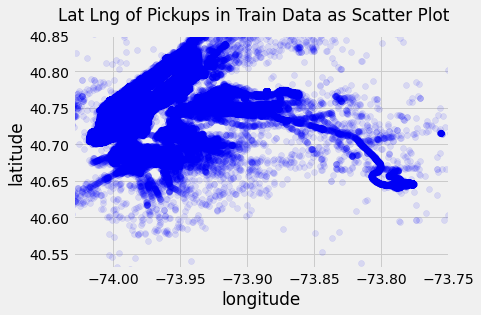

In [25]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.53, 40.85)
fig, ax = plt.subplots(ncols=1, sharex=True, sharey=True)
ax.scatter(train['pickup_longitude'], train['pickup_latitude'], color='blue', label='train', alpha=0.1)
fig.suptitle('Lat Lng of Pickups in Train Data as Scatter Plot')
ax.set_ylabel('latitude')
ax.set_xlabel('longitude')
plt.ylim(city_lat_border)
plt.xlim(city_long_border)

In [26]:
drop=train.groupby(['dropoff_latitude_round3','dropoff_longitude_round3'])['id'].count().reset_index().rename(columns={'id':'Num_Trips'})

In [27]:
drop.head()

,dropoff_latitude_round3,dropoff_longitude_round3,Num_Trips
0,32.181,-73.835,1
1,34.360,-65.848,1
2,35.174,-72.022,1
3,36.029,-77.441,1
4,36.119,-68.778,1


In [28]:
drop_map = folium.Map(location=[40.730610, -73.935242], zoom_start=10,)
hm_wide = HeatMap(list(zip(drop.dropoff_latitude_round3.values, drop.dropoff_longitude_round3.values, drop.Num_Trips)),
                 min_opacity=0.2,
                 radius=5, blur=15,
                 max_zoom=1)
drop_map.add_child(hm_wide)
drop_map

Dropoff Heatmap은 Pickup과 유사하다.

### pickup이 point로부터 왔을때, trip 시간 heatmap

In [29]:
pickup= train.groupby(['pickup_latitude_round3', 'pickup_longitude_round3'])['trip_duration'].mean().reset_index().rename(columns={'trip_duration':'Avg_Trip_duration'})

In [30]:
pickup.head()

,pickup_latitude_round3,pickup_longitude_round3,Avg_Trip_duration
0,34.360,-65.848,961.0
1,34.712,-75.354,875.0
2,35.082,-71.800,611.0
3,35.310,-72.074,317.0
4,36.029,-77.441,782.0


In [31]:
pickup_map = folium.Map(location= [40.730610, -73.935242], zoom_start=10,)
hm_wide = HeatMap(list(zip(pickup.pickup_latitude_round3.values, pickup.pickup_longitude_round3.values, pickup.Avg_Trip_duration)),
                 min_opacity=0.2,
                 radius=7, blur=15,
                 max_zoom=1)
pickup_map.add_child(hm_wide)
pickup_map

평균값은 트립이 JFK에서 시작할때 가장 높다. 좀더 들여다보면 맨하탄 이후임을 확인할 수 있다. 
JFK로부터 픽업은 높은 여행 시간을 가지는 경향이 있다.

## 2) 시간, 요일
### 어느 시간대가 높은가?

Text(0.5, 1.0, 'Pick Hours Distribution')

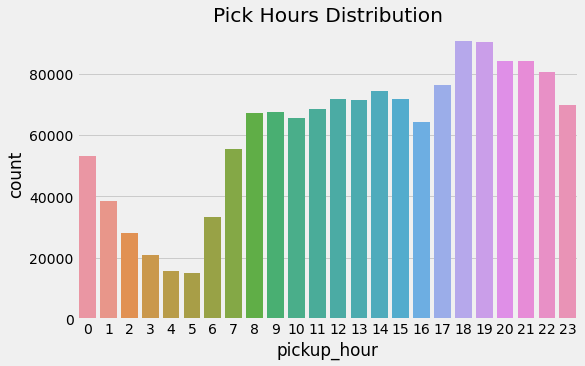

In [32]:
plt.figure(figsize=(8,5))
sns.countplot(x=train['pickup_hour']).set_title("Pick Hours Distribution")

이른 아침시간에는 적고, 오후 6~8시 사이가 피크임을 알 수 있다.

Text(0.5, 1.0, 'Dropoff Hours Distribution')

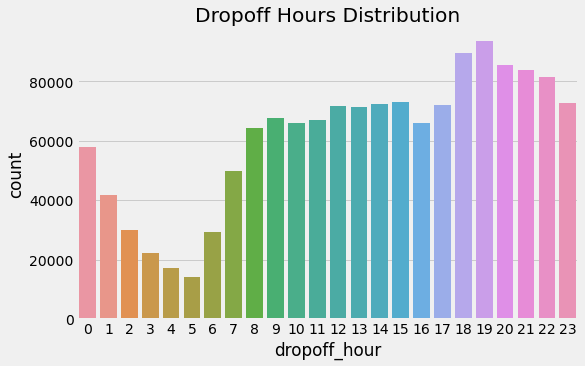

In [33]:
plt.figure(figsize=(8,5))
sns.countplot(x=train['dropoff_hour']).set_title("Dropoff Hours Distribution")

Drop 시간대도 pickup 시간대와 비슷하다.

### 전체 pickup 시간대 분포

Text(0.5, 1.0, 'Distribution of Pickups over time')

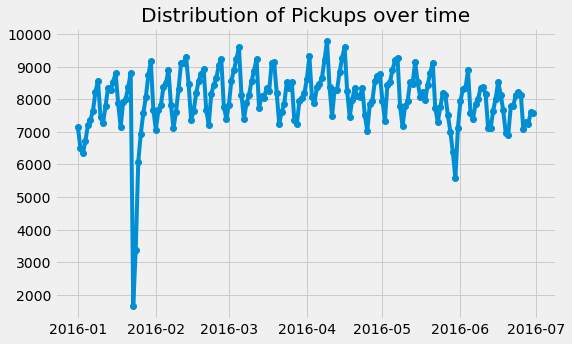

In [34]:
plt.figure(figsize=(8,5))
plt.plot(train.groupby('pickup_date').count()[['id']], 'o-', label='train')
plt.title("Distribution of Pickups over time")

2016년 2월을 끝으로 pickup의 숫자는 떨어지는 것으로 보인다.

### 시간대 별로 trip 기간이 높은 것은 ?

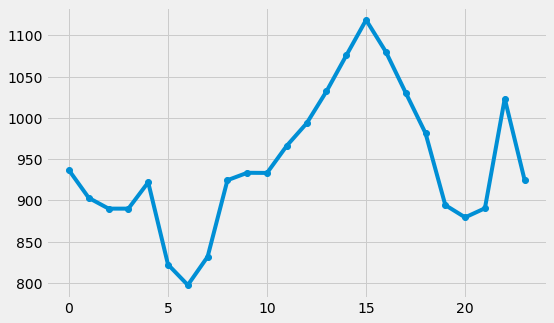

In [35]:
avg_duration_hour = train.groupby(['pickup_hour'])['trip_duration'].mean()
plt.figure(figsize=(8,5))
plt.plot(train.groupby(['pickup_hour'])['trip_duration'].mean(), 'o-')

10~15시간대 사이가 duration이 증가한다. 

### 요일별 pickup 배분 시간 

<AxesSubplot:xlabel='pickup_day_of_week', ylabel='count'>

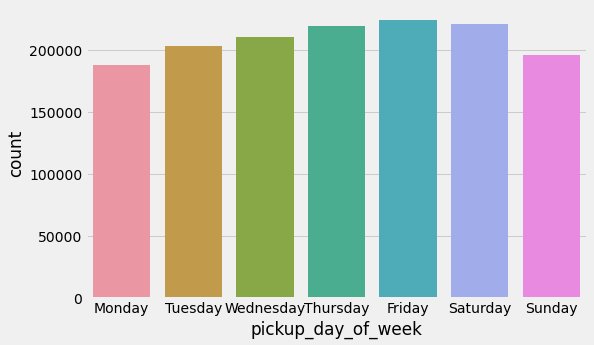

In [36]:
plt.figure(figsize=(8,5))
sns.countplot(train['pickup_day_of_week'],
              order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'
                    , 'Saturday', 'Sunday'])

pickup 비율은 월요일이 제일 낮고, 화요일부터 증가하다가 금요일이 제일 높다. 

### 요일별 평균 trip 기간

In [37]:
avg_duration_day = train.groupby(['pickup_day_of_week'])['trip_duration'].mean().reset_index().rename(columns={'trip_duration' : 'avg_trip_duration'})

Text(0.5, 1.0, 'Avg Trip Duration vs Pickup Days of Week')

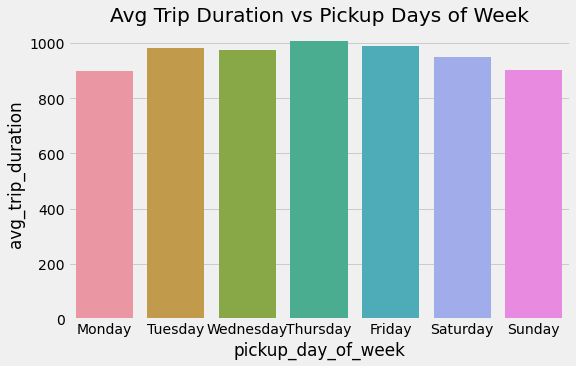

In [38]:
plt.figure(figsize=(8,5))
sns.barplot(x='pickup_day_of_week', y='avg_trip_duration', data=avg_duration_day, order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']).set_title("Avg Trip Duration vs Pickup Days of Week")

목요일이 가장 높다.

## 3) 거리, 지역, 속도
### Trip 거리 분포

In [39]:
train['trip_distance'].head()

0    1.499697
1    1.806924
2    6.390110
3    1.486664
4    1.189521
Name: trip_distance, dtype: float64

In [40]:
train['trip_duration'].head()

0    455 
1    663 
2    2124
3    429 
4    435 
Name: trip_duration, dtype: int64

In [41]:
# plt.figure(figsize=(8,5))
# sns.kdeplot(np.log(train['trip_distance'].values)).set_title("Trip Distance Distribution")
# sns.distplot(np.log(train['trip_distance'].values)).set_title("Distribution of Trip Duration") # cannot convert float infinity to integer
# sns.distplot(np.log(train['trip_distance'].values)).set_title("Trip Distance Distribution")
# plt.xlabel("Trip Distance (log)")

### trip duration vs trip distance 비교

Text(0, 0.5, 'Trip Duration (log scale)')

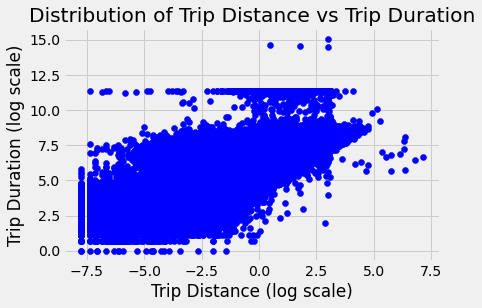

In [42]:
plt.scatter(np.log(train['trip_distance'].values),
            np.log(train['trip_duration'].values),
            color='blue', label='train'
            )
plt.title("Distribution of Trip Distance vs Trip Duration")
plt.xlabel("Trip Distance (log scale)")
plt.ylabel("Trip Duration (log scale)")

### 제공해주는 함수를 통해 여행 방향을 측정해본다. 

In [43]:
 def calculateBearing(lat1, lng1, lat2, lng2):
        R=6371
        lng_delta_rad = np.radians(lng2-lng1)
        lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
        y = np.sin(lng_delta_rad) * np.cos(lat2)
        x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
        return np.degrees(np.arctan2(y, x))   
        

In [44]:
train['bearing'] = train.apply(lambda row : calculateBearing(row['pickup_latitude_round3'], row['pickup_longitude_round3'], row['dropoff_latitude_round3'], row['dropoff_longitude_round3']), axis=1)
# train['bearing'] = train.apply(lambda row : calculateBearing(row['pickup_latitude_round3'], row['pickup_longitude_round3'], row['dropoff_latitude_round3'], row['dropoff_longitude_round3']),axis=1)

### bearing 분포

<AxesSubplot:>

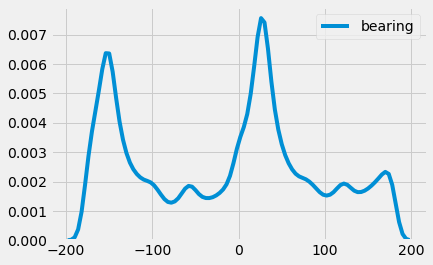

In [45]:
sns.kdeplot(train['bearing'])

### Bearing vs Trip Duration

Text(0, 0.5, 'Trip Duration (log scale)')

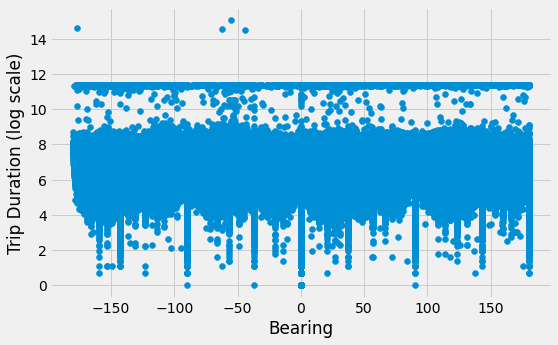

In [46]:
plt.figure(figsize=(8,5))
plt.scatter(train['bearing'].values, y=np.log(train['trip_duration'].values))
plt.xlabel("Bearing")
plt.ylabel("Trip Duration (log scale)")

-50 지점에서 outlier가 보인다.

### Store와 FWD Flag 분포

In [47]:
train['store_and_fwd_flag'].value_counts()

N    1450599
Y    8045   
Name: store_and_fwd_flag, dtype: int64

Text(0, 0.5, 'Destiny')

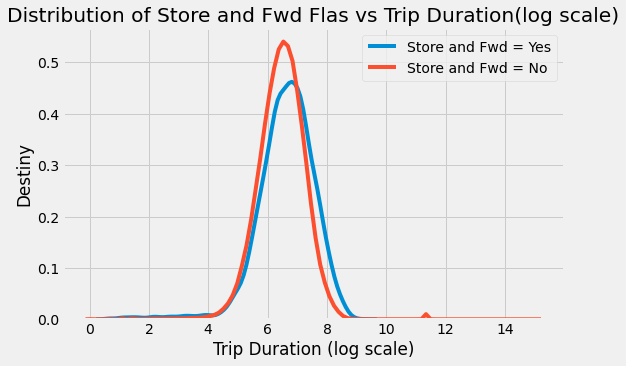

In [48]:
plt.figure(figsize=(8,5))
sns.kdeplot(np.log(train.loc[train['store_and_fwd_flag']=='Y', 'trip_duration'].values), label='Store and Fwd = Yes')
sns.kdeplot(np.log(train.loc[train['store_and_fwd_flag']=='N', 'trip_duration'].values), label='Store and Fwd = No')

plt.title("Distribution of Store and Fwd Flas vs Trip Duration(log scale)")
plt.xlabel('Trip Duration (log scale)')
plt.ylabel('Destiny')

여행의 5~7시간 여행에서는 Store and Fwd Flag 값이 No가 더 많이 분포되어 있다.

###  클러스터내에 지역 그룹
이것은 아마 지역을 생성하는데 도움이 될것이다. 특정 지역으로부터 pickup은 아마 긴 trip 시간을 가질 수 있다.

In [49]:
coords = np.vstack((train[['pickup_latitude','pickup_longitude']].values,
                   train[['dropoff_latitude','dropoff_longitude']].values,
                   test[['pickup_latitude','pickup_longitude']].values,
                   test[['dropoff_latitude','dropoff_longitude']].values))
kmeans = KMeans(n_clusters=8, random_state=0).fit(coords)

(-74.03, -73.75)

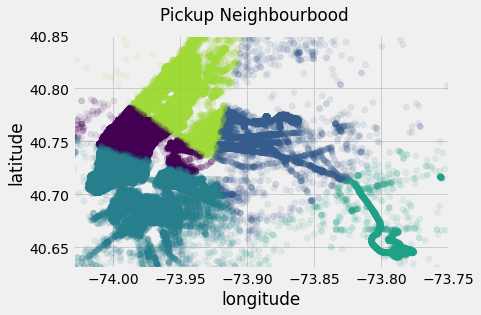

In [50]:
train.loc[:, 'pickup_neighbourhood'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train.loc[:, 'dropoff_neighbourhood'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=1, sharex=True, sharey=True)
ax.scatter(train['pickup_longitude'], train['pickup_latitude'],
          c=train['pickup_neighbourhood'], label='train', alpha=0.1)

fig.suptitle('Pickup Neighbourbood')
ax.set_ylabel('latitude')
ax.set_xlabel('longitude')
plt.ylim(city_lat_border)
plt.xlim(city_long_border)

예측한 값을 지도에 출력하였다.

### 각 지역안에서 pickup 수

Text(0.5, 1.0, 'Distribution of Number of Pickups across Neighbourhood')

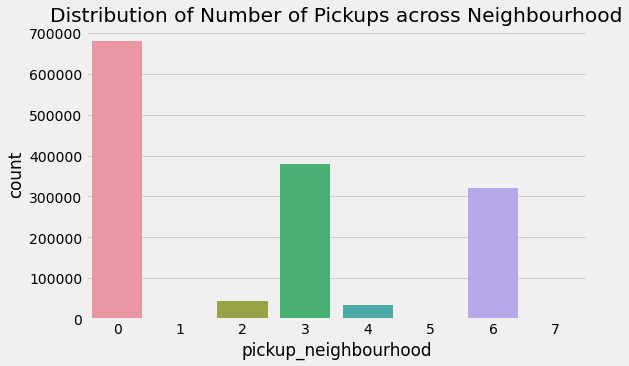

In [51]:
plt.figure(figsize=(8,5))
sns.countplot(train['pickup_neighbourhood']).set_title("Distribution of Number of Pickups across Neighbourhood")

지역 0, 3, 6 순으로 pickup 수치가 크다.

Text(0.5, 1.0, 'Avg Trip Duration vs Neighbourhood')

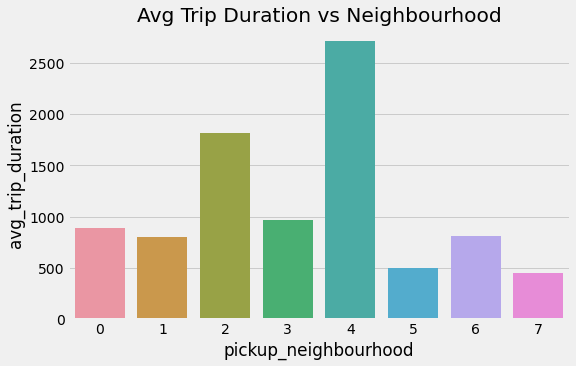

In [52]:
avg_duration_neighbourhood = train.groupby(['pickup_neighbourhood'])['trip_duration'].mean().reset_index().rename(columns={'trip_duration':'avg_trip_duration'})
plt.figure(figsize=(8,5))
sns.barplot(x='pickup_neighbourhood', y='avg_trip_duration', data=avg_duration_neighbourhood).set_title("Avg Trip Duration vs Neighbourhood")

- 4, 2 지역 순으로 평균 trip duration 시간이 길다. 
- 1, 5, 7은 위의 pickup neighbourhood 숫자가 0에 가까울지라도 평균 이용 기간은 높은 평균에 속한다.

### 평균 속도 분포

Text(0.5, 1.0, 'Distribution of Average Speed (in kph)')

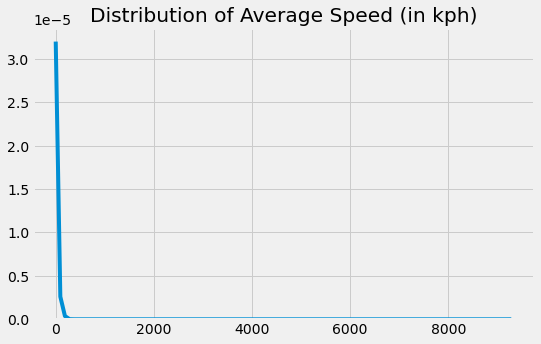

In [53]:
train['avg_speed_kph'] = train['trip_distance'] / train['trip_duration_in_hour']
plt.figure(figsize=(8,5))
sns.kdeplot(train['avg_speed_kph'].values).set_title("Distribution of Average Speed (in kph)")

In [54]:
print("Average speed is", np.mean(train['avg_speed_kph']), "kph")

Average speed is 14.434528392345062 kph


### 일주일의 요일 평균 속도 - 교통 속도를 의미함.

Text(0.5, 1.0, 'Avg Speed (kph) vs Pickup Days of Week')

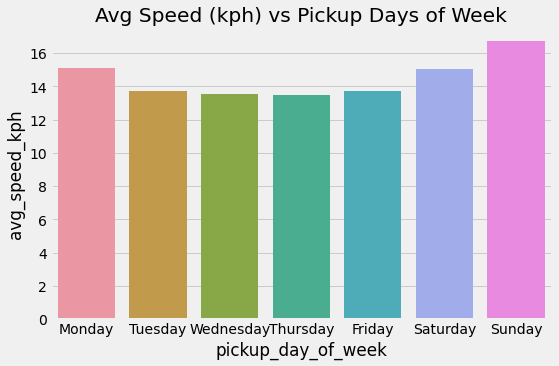

In [55]:
avg_speed_per_day = train.groupby(['pickup_day_of_week'])['avg_speed_kph'].mean().reset_index()
plt.figure(figsize=(8,5))
sns.barplot(x='pickup_day_of_week', y='avg_speed_kph', data=avg_speed_per_day, order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']).set_title("Avg Speed (kph) vs Pickup Days of Week")

일요일과 월요일에 평균 속도가 높다.

# 4. Feature Engineering 
모델 적용을 위해 test data를 featrue engineering을 한다.

In [56]:
test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
test['pickup_date'] = test['pickup_datetime'].dt.date
test['pickup_day'] = test['pickup_datetime'].apply(lambda x:x.day)
test['pickup_hour'] = test['pickup_datetime'].apply(lambda x:x.hour)
test['pickup_day_of_week'] = test['pickup_datetime'].apply(lambda x:calendar.day_name[x.weekday()])

test['pickup_latitude_round3']=test['pickup_latitude'].apply(lambda x:round(x,3))
test['pickup_longitude_round3']=test['pickup_longitude'].apply(lambda x:round(x,3))
test['dropoff_latitude_round3']=test['dropoff_latitude'].apply(lambda x:round(x,3))
test['dropoff_longitude_round3']=test['dropoff_longitude'].apply(lambda x:round(x,3))
test['trip_distance'] = test.apply(lambda row : calculateDistance(row), axis=1)

test['bearing']=test.apply(lambda row:calculateBearing(row['pickup_latitude_round3'], 
                                                       row['pickup_longitude_round3'], row['dropoff_latitude_round3'], row['dropoff_longitude_round3']), axis=1)
test.loc[:,'pickup_neighbourhood'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test.loc[:,'dropoff_neighbourhood'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])

In [57]:
drop_cols=['avg_speed_kph','trip_duration_in_hour','dropoff_date','dropoff_day','dropoff_hour','dropoff_day_of_week','dropoff_datetime','pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude']
training = train.drop(drop_cols, axis=1)
testing=test.drop(['pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude'], axis=1)

In [58]:
training

,id,vendor_id,pickup_datetime,passenger_count,store_and_fwd_flag,trip_duration,pickup_date,pickup_day,pickup_hour,pickup_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3,trip_distance,bearing,pickup_neighbourhood,dropoff_neighbourhood
0,id2875421,2,2016-03-14 17:24:55,1,N,455,2016-03-14,14,17,Monday,40.768,-73.982,40.766,-73.965,1.499697,98.823984,0,6
1,id2377394,1,2016-06-12 00:43:35,1,N,663,2016-06-12,12,0,Sunday,40.739,-73.980,40.731,-73.999,1.806924,-119.053505,0,3
2,id3858529,2,2016-01-19 11:35:24,1,N,2124,2016-01-19,19,11,Tuesday,40.764,-73.979,40.710,-74.005,6.390110,-159.948291,0,3
3,id3504673,2,2016-04-06 19:32:31,1,N,429,2016-04-06,6,19,Wednesday,40.720,-74.010,40.707,-74.012,1.486664,-173.347990,3,3
4,id2181028,2,2016-03-26 13:30:55,1,N,435,2016-03-26,26,13,Saturday,40.793,-73.973,40.783,-73.973,1.189521,180.000000,6,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,4,N,778,2016-04-08,8,13,Friday,40.746,-73.982,40.740,-73.995,1.226042,-121.344499,0,3
1458640,id1049543,1,2016-01-10 07:35:15,1,N,655,2016-01-10,10,7,Sunday,40.747,-74.001,40.797,-73.970,6.054584,25.141571,0,6
1458641,id2304944,2,2016-04-22 06:57:41,1,N,764,2016-04-22,22,6,Friday,40.769,-73.959,40.707,-74.004,7.830747,-151.176950,6,3
1458642,id2714485,1,2016-01-05 15:56:26,1,N,373,2016-01-05,5,15,Tuesday,40.749,-73.982,40.757,-73.975,1.093421,33.535703,0,0


In [59]:
training['log_trip_duration'] = training['trip_duration'].apply(lambda x : np.log(x))
training.drop(['trip_duration'], axis=1, inplace=True)

In [60]:
print("Training Data Shape", training.shape)
print("Testing Data Shape", testing.shape)

Training Data Shape (1458644, 18)
Testing Data Shape (625134, 17)


일주일의 요일을 숫자로 encode 해보자.

In [61]:
def encodeDay(day_of_week):
    day_dict = {'Sunday' :0, 'Monday':1, 'Tuesday':2 ,'Wednesday':3, 'Thursday':4, 'Friday':5, 'Saturday':6}
    return day_dict[day_of_week]

In [62]:
training['pickup_day_of_week'] = training['pickup_day_of_week'].apply(lambda x:encodeDay(x))
testing['pickup_day_of_week'] = testing['pickup_day_of_week'].apply(lambda x:encodeDay(x))

In [63]:
training.to_csv("input_training.csv", index=False)
testing.to_csv("input_testing.csv", index=False)

del training
del testing
del train
del test

In [65]:
def LabelEncoding(train_df, test_df, max_levels=2):
    for col in train_df:
        if len(list(train_df[col].unique())) <= max_levels:
            le = preprocessing.LabelEncoder()
            le.fit(train_df[col])
            train_df[col] = le.transform(train_df[col])
            test_df[col] = le.transform(test_df[col])
    return [train_df, test_df]

def readInputAndEncode(input_path, train_file, test_file, target_column):
    training = pd.read_csv(input_path+train_file)
    testing = pd.read_csv(input_path+test_file)
    
    training, testing = LabelEncoding(training, testing)
    
    print("Training Data Shape after Encoding ", training.shape)
    print("Testing Data Shape after Encoding ", testing.shape)
    
    train_cols = training.columns.tolist()
    test_cols = testing.columns.tolist()
    col_in_train_not_test = set(train_cols) -set(test_cols)
    
    for col in col_in_train_not_test:
        if col!=target_column:
            testing[col] = 0
    col_in_test_not_train = set(test_cols) -set(train_cols)
    for col in col_in_test_not_train:
        training[col]=0
    print("---------------")
    print("Training Data Shape after Processing ", training.shape)
    print("Testing Data Shape after Processing ", testing.shape)
    
    return [training, testing]   
    

In [66]:
train, test = readInputAndEncode("", 'input_training.csv', 'input_testing.csv', 'log_trip_duration')
train.drop(['pickup_date'], axis=1, inplace=True)
test.drop(['pickup_date'], axis=1, inplace=True)
train.drop(['pickup_datetime'], axis=1, inplace=True)
test.drop(['pickup_datetime'], axis=1, inplace=True)
test_id = test['id']
train.drop(['id'], axis=1, inplace=True)
test.drop(['id'], axis=1, inplace=True)

Training Data Shape after Encoding  (1458644, 18)
Testing Data Shape after Encoding  (625134, 17)
---------------
Training Data Shape after Processing  (1458644, 18)
Testing Data Shape after Processing  (625134, 17)


# 5. 모델 적용


## 1) 모델 세우기

In [72]:
def GetFeatureAndSplit(train, test, target, imputing_strategy='median', split=0.25, imputation=True ):
    labels=np.array(train[target])
    training = train.drop(target, axis=1)
    training = np.array(training)
    testing = np.array(test)
    
    if imputation == True:
        imputer = SimpleImputer(strategy=imputing_strategy, missing_values=np.nan)
        imputer.fit(training)
        training = imputer.transform(training)
        testing = imputer.transform(testing)
    
    train_features, validation_features, train_labels, validation_labels = train_test_split(training, labels, test_size= split, random_state=42)
    return [train_features, validation_features, train_labels, validation_labels, testing]

In [76]:
train_features, validation_features, train_labels, validation_labels, testing=GetFeatureAndSplit(train, test, 'log_trip_duration', imputation=True)

## 2) 선형 모델 적용

In [77]:
lm = linear_model.LinearRegression()
lm.fit(train_features, train_labels)

LinearRegression()

In [79]:
valid_pred = lm.predict(validation_features)

In [80]:
rmse = mean_squared_error(validation_labels, valid_pred)
print("Root Mean Squared Error for Linear Regression(log scale)", rmse)

Root Mean Squared Error for Linear Regression(log scale) 0.4003474301960613


In [81]:
test_pred = lm.predict(testing)
submit= pd.DataFrame()
submit['id'] = test_id
submit['trip_duration'] = np.exp(test_pred)
submit.to_csv("submission_linear_regression_baseline.csv", index = False)

## 3) 랜덤포레스트 적용 

In [82]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(train_features, train_labels)

RandomForestRegressor(random_state=42)

In [83]:
valid_pred_rf= rf.predict(validation_features)
rmse=mean_squared_error(validation_labels, valid_pred_rf)
print("Root Mean Squared Error for Random Forest", rmse)

Root Mean Squared Error for Random Forest 0.16593325812733248


In [84]:
test_pred=rf.predict(testing)
submit = pd.DataFrame()
submit['id'] = test_id
submit['trip_duration'] = np.exp(test_pred)
submit.to_csv("submission_random_forest_baseline.csv", index=False)